# Анализ рынка заведений общественного питания Москвы

В данном проекте проводится исследование рынка общепита в Москве с целью получить инвестиции под небольше кафе, в котором гостей будут обслуживать роботы. Проект многообещающий, но дорогой. Вместе с партнёрами мы решились обратиться к инвесторам. Их интересует текущее положение дел на рынке — сможем ли мы снискать популярность на долгое время, когда все зеваки насмотрятся на роботов-официантов?
В нашем распоряжении есть открытые данные о заведениях общественного питания в Москве и на их основе будет составлена презентация по итогам анализа.

## Изучение данных и предобработка

In [1]:
import numpy as np 
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from pymystem3 import Mystem
import re

In [2]:
data = pd.read_csv('C:/Users/Анастасия/Documents/Jupiter_project/projects/story_with_data/rest_data.csv')

Ознакомимся с представленными данными:

In [3]:
data.info()
display(data.head())
print(data.columns)
pd.DataFrame(round((data.isna().mean() * 100), 2), columns=['NaNs,%']).style.format('{:.2f}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


Index(['id', 'object_name', 'chain', 'object_type', 'address', 'number'], dtype='object')


,"NaNs,%"
id,0.00
object_name,0.00
chain,0.00
object_type,0.00
address,0.00
number,0.00


Таблица `rest_data`:
  
`id` — идентификатор объекта;  
`object_name` — название объекта общественного питания;  
`chain` — сетевой ресторан;  
`object_type` — тип объекта общественного питания;  
`address` — адрес;  
`number` — количество посадочных мест.  

Типы данных по столбцам ок, названия самих столбцов тоже, пропусков в данных нет. Для дальнейшего удобства и исключения дубликатов приведем информацию в таблице полностью к нижнему регистру:

In [4]:
for column in data.columns:
    try:
        data[column] = data[column].str.lower()
    except:
        continue
data.head()

,id,object_name,chain,object_type,address,number
0,151635,сметана,нет,кафе,"город москва, улица егора абакумова, дом 9",48
1,77874,родник,нет,кафе,"город москва, улица талалихина, дом 2/1, корпус 1",35
2,24309,кафе «академия»,нет,кафе,"город москва, абельмановская улица, дом 6",95
3,21894,пиццетория,да,кафе,"город москва, абрамцевская улица, дом 1",40
4,119365,кафе «вишневая метель»,нет,кафе,"город москва, абрамцевская улица, дом 9, корпус 1",50


Проверим данные на наличие дубликатов:

In [5]:
print('Полных дубликатов строк', data.duplicated().sum())

Полных дубликатов строк 0


Полных дубликатов нет, но посмотрим внимательнее по значениям в ключевых столбцах:

In [6]:
print('Дубликатов строк', data[data.duplicated(['object_name', 'chain', 'object_type', 'address', 'number'])]['id'].count())
data[data.duplicated(['object_name', 'chain', 'object_type', 'address', 'number'])].head(15)

Дубликатов строк 85


,id,object_name,chain,object_type,address,number
2381,28611,комбинат питания мгту им.н.э.баумана,нет,столовая,"город москва, 2-я бауманская улица, дом 5, стр...",100
3397,71896,буфет «коникс-школьник»,нет,буфет,"город москва, улица удальцова, дом 21",100
3481,20914,буфет мади,нет,буфет,"город москва, ленинградский проспект, дом 64",40
4431,23759,столовая гбоу города москвы № 384,нет,буфет,"город москва, беловежская улица, дом 67",100
4537,23391,столовая «комбинат питания космос»,нет,столовая,"город москва, новозаводская улица, дом 12/11",15
5059,20021,lift,нет,кафе,"город москва, багратионовский проезд, дом 7, к...",20
5069,20025,lift,нет,кафе,"город москва, багратионовский проезд, дом 7, к...",10
5147,145227,кафе при азс,нет,кафе,"город москва, огородный проезд, дом 7, строение 1",0
5185,107442,кафе,нет,кафе,"город москва, 1-я останкинская улица, дом 55",20
5186,107574,кафе,нет,кафе,"город москва, 1-я останкинская улица, дом 55",10


Как видим, есть дубликаты по данным столбцам, при этом название "кафе" плохо идентифицирует заведение, не факт, что это дубликат, а не разные заведения по одному адресу, но таких строк 85, лучше от них избавиться:

In [7]:
data = data.drop_duplicates(subset=['object_name', 'chain', 'object_type', 'address', 'number'], keep="last")

Проверим значения по отдельным столбцам на "адекватность":

In [8]:
data['chain'].value_counts()

нет    12317
да      2964
Name: chain, dtype: int64

In [9]:
data['object_type'].value_counts()

кафе                                 6071
столовая                             2584
ресторан                             2282
предприятие быстрого обслуживания    1897
бар                                   855
буфет                                 576
кафетерий                             395
закусочная                            348
магазин (отдел кулинарии)             273
Name: object_type, dtype: int64

Заменим некоторые значеняи на аналогичные по смыслу, но более компактные и простые для восприятия.

In [10]:
data['object_type'] = np.where(data['object_type'] == 'магазин (отдел кулинарии)', 'кулинария', data['object_type'])
data['object_type'] = np.where(data['object_type'] == 'предприятие быстрого обслуживания', 'fast food', data['object_type'])
data['object_type'].value_counts()

кафе          6071
столовая      2584
ресторан      2282
fast food     1897
бар            855
буфет          576
кафетерий      395
закусочная     348
кулинария      273
Name: object_type, dtype: int64

In [11]:
data['number'].describe()

count    15281.000000
mean        59.788234
std         74.843042
min          0.000000
25%         14.000000
50%         40.000000
75%         80.000000
max       1700.000000
Name: number, dtype: float64

В целом информация выглядит правдиво, без каких-либо выбросов и ошибок.

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15281 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15281 non-null  int64 
 1   object_name  15281 non-null  object
 2   chain        15281 non-null  object
 3   object_type  15281 non-null  object
 4   address      15281 non-null  object
 5   number       15281 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 835.7+ KB


<div style="border:solid SandyBrown 2px; padding: 20px">  
    Вывод: в результате предобработки не было обнаружено полных дубликатов, пропусков или каких-либо очевидных ошибок в данных. Все типы данных приведены к максимально удобным. Названия столбцов соотвествуют общепринятому стилю. Информация в стобцах также была приведена в нижнему регистру для удобства. Удалены неполные дубликаты(85 строк). Итоговый датасет содержит 15281 строку.

## Анализ данных

### Cоотношение видов объектов общественного питания по количеству

In [13]:
types = data.pivot_table(index='object_type', 
                               values = 'id', 
                               aggfunc = 'count').reset_index().sort_values(by='id', ascending=False)
types

,object_type,id
4,кафе,6071
8,столовая,2584
7,ресторан,2282
0,fast food,1897
1,бар,855
2,буфет,576
5,кафетерий,395
3,закусочная,348
6,кулинария,273


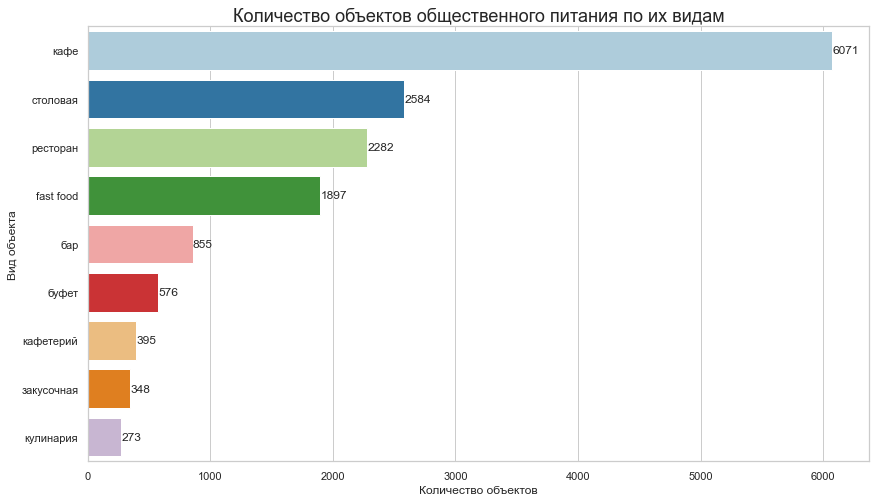

In [14]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(14, 8))
ax = sns.barplot(x = 'id', y = 'object_type', data = types, palette="Paired")


for p in ax.patches:
    height = p.get_height() 
    width = p.get_width() 
    ax.text(x = width+3, 
    y = p.get_y()+(height/2), 
    s = '{:.0f}'.format(width),
    va = 'center')
    
plt.xlabel('Количество объектов')
plt.ylabel('Вид объекта')
plt.title('Количество объектов общественного питания по их видам', fontsize = 18);
#plt.savefig('1.png');

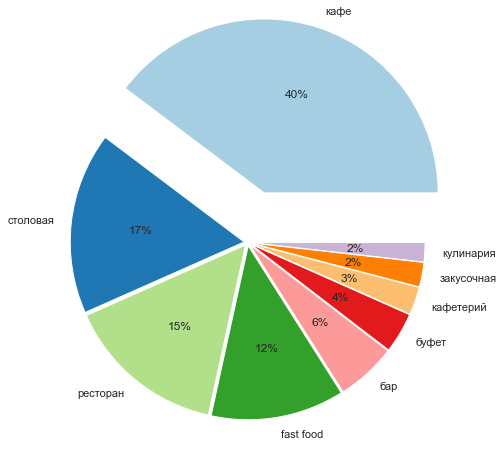

In [15]:
plt.figure(figsize=(10, 8))
explode = [0.3,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02]
colors = sns.color_palette('Paired')
plt.pie(types['id'], labels=types['object_type'], colors = colors, autopct = '%0.0f%%', explode = explode);
#plt.savefig('2.png');

40% объектов составляют кафе, в абсолютных величинах это 6071 объект. На втором месте по популярности столовые - 17%, 2584 объекста. Меньше всего кулинарий, закусочных и кафетериев, суммарно их менее 10% от общего числа.

### Cоотношение сетевых и несетевых заведений по количеству

In [16]:
chain = data.pivot_table(index='chain', 
                               values = 'id', 
                               aggfunc = 'count').reset_index().sort_values(by='id', ascending=False)
chain

,chain,id
1,нет,12317
0,да,2964


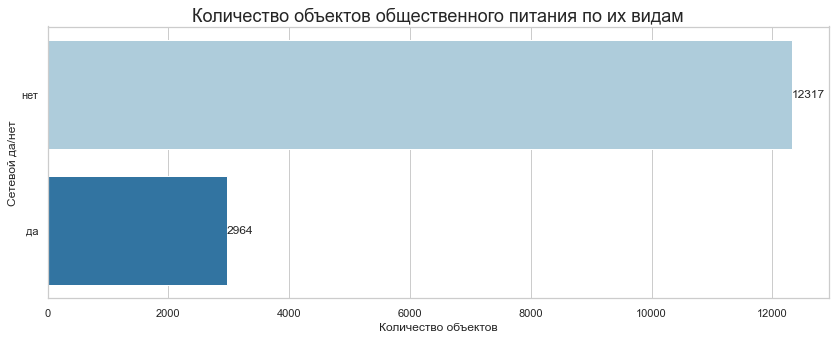

In [17]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(14, 5))
ax = sns.barplot(x = 'id', y = 'chain', data = chain, palette="Paired")


for p in ax.patches:
    height = p.get_height() 
    width = p.get_width() 
    ax.text(x = width+3, 
    y = p.get_y()+(height/2), 
    s = '{:.0f}'.format(width),
    va = 'center')
    
plt.xlabel('Количество объектов')
plt.ylabel('Сетевой да/нет')
plt.title('Количество объектов общественного питания по их видам', fontsize = 18);
#plt.savefig('3.png');

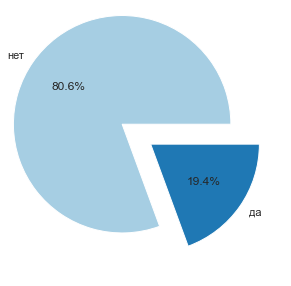

In [18]:
plt.figure(figsize=(10, 5))
explode = [0.3,0.02]
colors = sns.color_palette('Paired')
plt.pie(chain['id'], labels=chain['chain'], colors = colors, autopct = '%1.1f%%', explode = explode);
#plt.savefig('4.png');

Несетевых объектов абслоютное большинство - 80,6% против сетевых 19,4%. В абсолютных величинах это 12317 против 2964.

### Для какого вида объекта общественного питания характерно сетевое распространение?

In [19]:
types_chain = data.pivot_table(index=['object_type','chain'], values = 'id', aggfunc='count').reset_index()
types_chain

,object_type,chain,id
0,fast food,да,788
1,fast food,нет,1109
2,бар,да,37
3,бар,нет,818
4,буфет,да,11
5,буфет,нет,565
6,закусочная,да,56
7,закусочная,нет,292
8,кафе,да,1396
9,кафе,нет,4675


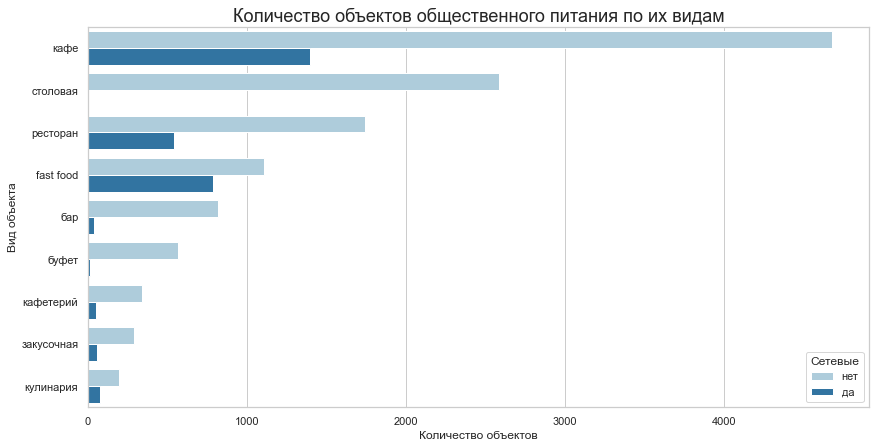

In [20]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(14, 7))
sns.barplot(x='id', hue='chain', y='object_type', data=types_chain.sort_values(by='id', ascending=False), palette="Paired")
plt.legend(title='Сетевые')
plt.xlabel('Количество объектов')
plt.ylabel('Вид объекта')
plt.title('Количество объектов общественного питания по их видам', fontsize = 18);
#plt.savefig('5.png');

In [21]:
ratio_chain = data.pivot_table(index='object_type', values = 'object_name', columns=['chain'], aggfunc='count').reset_index()
ratio_chain['all'] = ratio_chain['да'] + ratio_chain['нет']
ratio_chain['ratio'] = round(100*ratio_chain['да']/ratio_chain['all'],1)

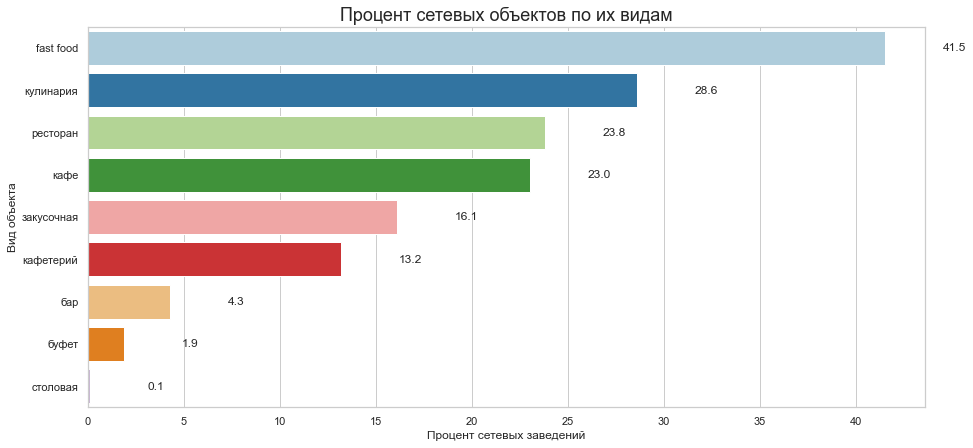

In [22]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15, 7))
ax = sns.barplot(x = 'ratio', y = 'object_type', data = ratio_chain.sort_values(by='ratio', ascending=False), palette="Paired")


for p in ax.patches:
    height = p.get_height() 
    width = p.get_width() 
    ax.text(x = width+3, 
    y = p.get_y()+(height/2), 
    s = '{:.1f}'.format(width),
    va = 'center')
    
plt.xlabel('Процент сетевых заведений')
plt.ylabel('Вид объекта')
plt.title('Процент сетевых объектов по их видам', fontsize = 18);
#plt.savefig('6.png');

Наиболее характерно сетевое распространение для fast foodов - 41,5% и кулинарий - 28,6% из них именно сетевые, наименее распротранены сетевые столовые и буфеты. При этом в абсолютном количестве сетевых кафе больше fast foodов.

### Что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?

In [23]:
chain_yes = data.query('chain=="да"')
chain_pivot = chain_yes.pivot_table(index='object_name', 
                                    values='number', 
                                    aggfunc=['count','mean']).round(1).reset_index()
chain_pivot.columns = ['chain_name', 'count', 'mean_number']
chain_pivot.sort_values(by='count', ascending=False).head(10)

,chain_name,count,mean_number
563,шоколадница,157,57.2
25,kfc,155,55.3
330,макдоналдс,150,87.7
109,бургер кинг,137,46.6
521,теремок,94,25.6
311,крошка картошка,90,21.9
159,домино'с пицца,90,18.3
339,милти,72,1.3
505,суши wok,72,6.7
367,папа джонс,51,22.0


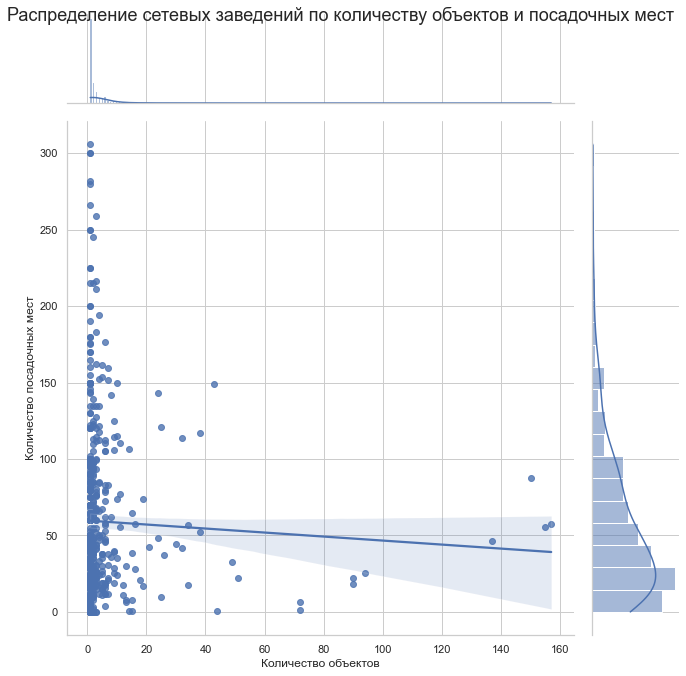

In [24]:
ax = sns.jointplot(x='count', y='mean_number', data=chain_pivot, kind='reg')
ax.fig.set_figwidth(10)
ax.fig.set_figheight(10)
ax.fig.suptitle('Распределение сетевых заведений по количеству объектов и посадочных мест', fontsize = 18)
ax.set_axis_labels('Количество объектов', 'Количество посадочных мест');
#plt.savefig('7.png');

Исходя из графика видно, что основная масса сетевых заведений имеет малое количество объектов, в большинстве случаев до 10 и не большое количество посадочных мест - до 50.

### Cреднее количество посадочных мест по видам объектов

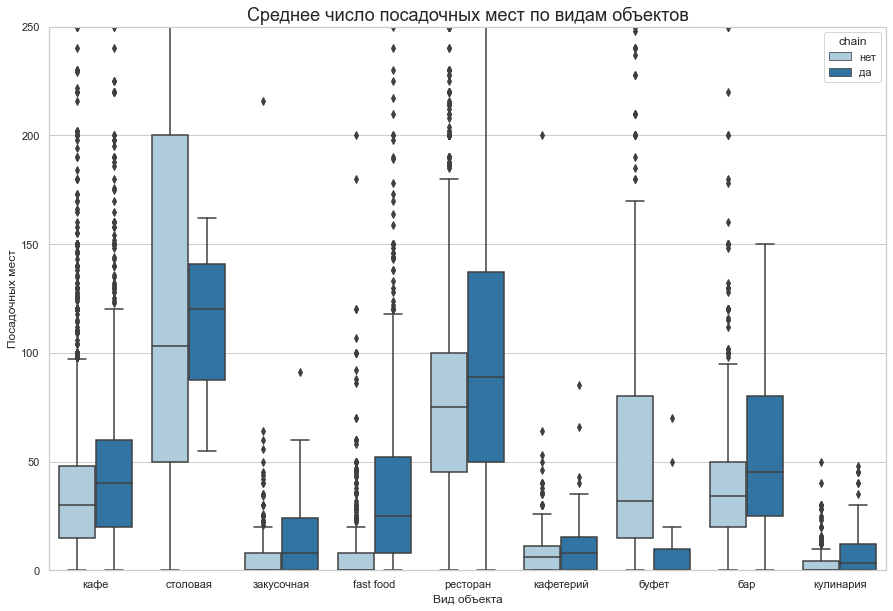

In [25]:
plt.figure(figsize=(15, 10))
ax = sns.boxplot(x='object_type', y='number', data=data, palette="Paired", hue='chain')
ax.set_ylim(0,250)
plt.xlabel('Вид объекта')
plt.ylabel('Посадочных мест')
plt.title('Среднее число посадочных мест по видам объектов', fontsize = 18);
#plt.savefig('8.png');

По графикам распределений видно, что наибольшее число посадочных мест в среднем пердлагают столовые, далее следуют рестораны. Наименьшее число посадочных мест в закусочных, кулинариях, и кафетериях, как мы видели в начале анализа данных, их может не быть в принципе. У fast foodа при этом самый большой разброс значений.

In [26]:
mean_number_chain = data.pivot_table(index=['object_type','chain'], values='number', aggfunc='mean').round(1)
mean_number_chain= mean_number_chain.sort_values(by='number', ascending=False).reset_index()
mean_number = data.pivot_table(index='object_type', values='number', aggfunc='mean').round(1)
mean_number = mean_number.sort_values(by='number', ascending=False).reset_index()

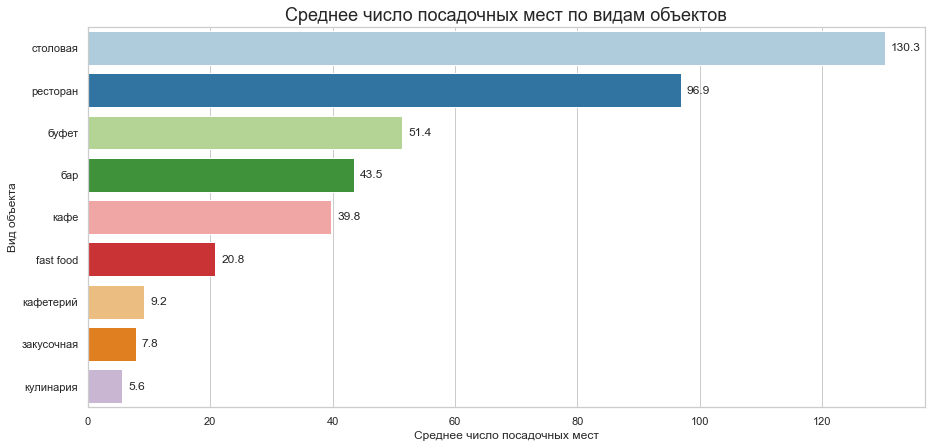

In [27]:
plt.figure(figsize=(15, 7))
ax = sns.barplot(x = 'number', y = 'object_type', data = mean_number[['object_type','number']], palette='Paired')


for p in ax.patches:
    height = p.get_height() 
    width = p.get_width() 
    ax.text(x = width+1, 
    y = p.get_y()+(height/2), 
    s = '{:.1f}'.format(width),
    va = 'center')
    
plt.xlabel('Среднее число посадочных мест')
plt.ylabel('Вид объекта')
plt.title('Среднее число посадочных мест по видам объектов', fontsize = 18);
#plt.savefig('9.png');

Рассмотрим также количество посадочных мест по видам объектов в разрезе их форматов:

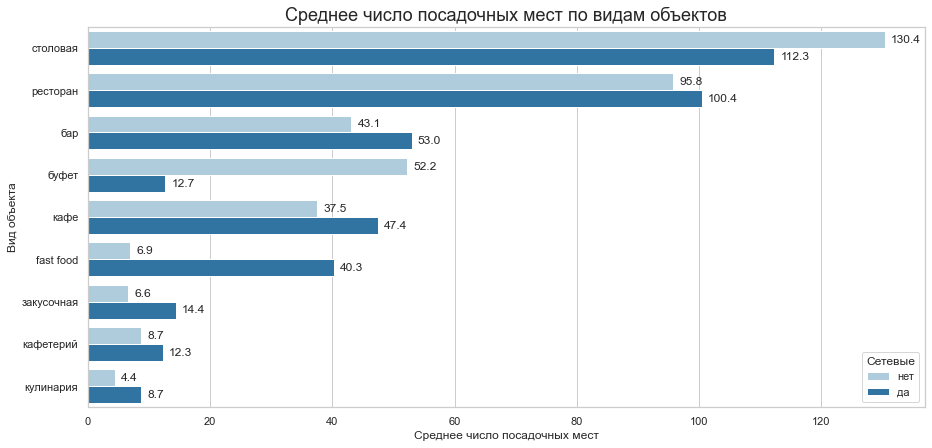

In [28]:
plt.figure(figsize=(15, 7))
ax = sns.barplot(x = 'number', y = 'object_type', hue='chain', data = mean_number_chain, palette="Paired")


for p in ax.patches:
    height = p.get_height() 
    width = p.get_width() 
    ax.text(x = width+1, 
    y = p.get_y()+(height/2), 
    s = '{:.1f}'.format(width),
    va = 'center')
    
plt.xlabel('Среднее число посадочных мест')
plt.ylabel('Вид объекта')
plt.legend(title='Сетевые')
plt.title('Среднее число посадочных мест по видам объектов', fontsize = 18);
#plt.savefig('13.png');

Как видим из графика формат заведения сетевое или нет вносит определенные отличия в количество средних мест в разных видах объектов. И в основном для сетевых заведений количество посадочных мест выше, чем для несетвых аналогичного вида. В сетевых fast foodах данный показатель отличается наибольшим образом - на 30 мест. А вот в буфетах и столовых, наоборот, посадочных мест у несетевых объектов больше.

### Анализ географии объектов

С помощью регулярных выражений "вытащим" название улиц в отдельный столбец:

In [29]:
words = ['проезд','пр.','прзд.','шоссе','шос.','ш.','улица','ул.','переулок','пер.','микрорайон','мкр.','мкрн.', \
         'мкад','Московской Кольцевой Автодороги','деревня','проспект','пр.','площадь','пл','село','аллея','бульвар', \
         'набережная','наб.','тупик','линия','посёлок','территория','квартал','просек','вблизи', 'парк','мост']
str_pat = r".*,\s*\b([^,]*?(?:{})\b[^,]*)[,$]+".format("|".join(words))
data['street'] = data['address'].str.extract(str_pat, flags=re.I)

In [30]:
data[data['street'].isna()]

,id,object_name,chain,object_type,address,number,street
859,23601,буфет - гбоу сош № 64,нет,буфет,"партизанская улица, дом 30",100,NaN
860,23604,буфет - гбоу 60,нет,буфет,"партизанская улица, дом 30",100,NaN
1405,20199,это,нет,кафе,"город москва, город зеленоград, корпус 401",35,NaN
1406,68113,френдс,нет,кафе,"город москва, город зеленоград, корпус 435",34,NaN
1407,20105,кафе «граф монте-кристо»,нет,кафе,"город москва, город зеленоград, корпус 436",40,NaN
...,...,...,...,...,...,...,...
14468,205933,кафе «империя бургеров»,нет,кафе,"город москва, город зеленоград, корпус 1106е",24,NaN
14470,220595,пекарня № 1,нет,кафетерий,"город москва, город зеленоград, корпус 1627",6,NaN
14473,220978,бар суши takai,нет,кафе,"город москва, город зеленоград, корпус 1602а",28,NaN
14478,211676,никольский,нет,ресторан,"город москва, город зеленоград, корпус 532",120,NaN


Видим, что осталось 192 строки без улицы, также видим, что бОльшая часть это адреса, у которых и нет улиц, в Зеленограде такие адреса. Оставим так, на анализ они сильно не повлияют в любом случае.

Построим график топ-10 улиц по количеству объектов общественного питания.

In [31]:
top_10 = data.pivot_table(index='street', 
                          values='id', 
                          aggfunc='count').reset_index().sort_values(by='id', ascending=False).head(10)
top_10

,street,id
1148,проспект мира,203
1152,профсоюзная улица,181
754,ленинградский проспект,170
1104,пресненская набережная,167
436,варшавское шоссе,164
757,ленинский проспект,147
1144,проспект вернадского,128
744,кутузовский проспект,114
664,каширское шоссе,111
674,кировоградская улица,108


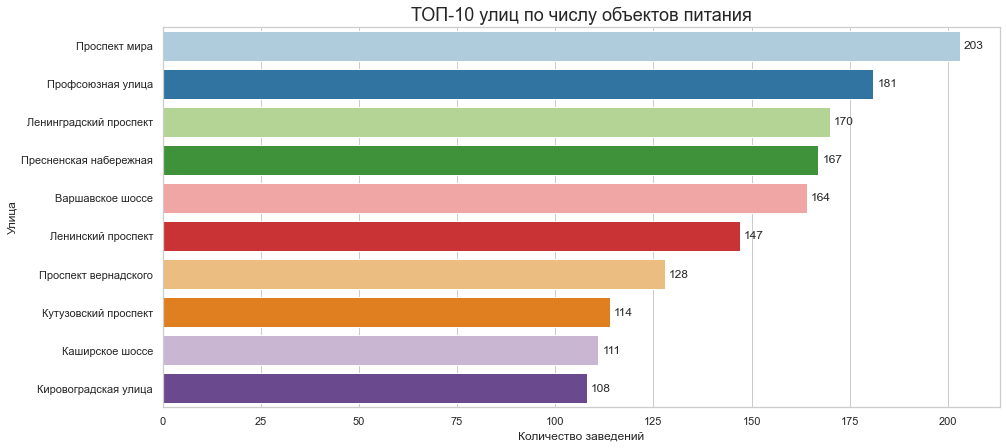

In [32]:
top_10['street'] = top_10['street'].str.capitalize()
plt.figure(figsize=(15, 7))
ax = sns.barplot(x = 'id', y = 'street', data = top_10, palette="Paired")


for p in ax.patches:
    height = p.get_height() 
    width = p.get_width() 
    ax.text(x = width+1, 
    y = p.get_y()+(height/2), 
    s = '{:.0f}'.format(width),
    va = 'center')
    
plt.xlabel('Количество заведений')
plt.ylabel('Улица')
plt.title('ТОП-10 улиц по числу объектов питания', fontsize = 18);
#plt.savefig('10.png');

По графику видим, что лидер по количеству заведений - Проспект Мира - 203, далее следуют Профсоюзная улица и Ленинградский проспект. Наименьшее количество объектов из топ-10 находятся на улице Кировоградской - 108шт.

Определим в каких районах Москвы находтся объекты с топ-10 улиц:

In [33]:
top_10_list = top_10['street'].unique()
district = data.query('street in @top_10_list')
district.head()

,id,object_name,chain,object_type,address,number,street


Воспользуюмся готовым файлом с полученными данными по геокоординатам.

In [34]:
url = 'https://docs.google.com/spreadsheets/d/1pC7miwkIyhUl_N_hwvy1rUNoryklAo0IyxtkIGK9Sy4/edit?usp=sharing'
url.split('/')
id = url.split('/')[5]
district_top = pd.read_csv(f'https://docs.google.com/spreadsheets/d/{id}/export?format=csv')
district_top

,id,object_name,chain,object_type,address,number,street,district
0,155973,кафе «андерсон»,Сетевое,кафе,"город москва, варшавское шоссе, дом 2",150,варшавское шоссе,Donskoy
1,23618,кафе «subway»,Сетевое,кафе,"город москва, варшавское шоссе, дом 7, корпус 1",36,варшавское шоссе,Donskoy
2,155852,кафе «ламаджо»,Несетевое,кафе,"город москва, варшавское шоссе, дом 29",30,варшавское шоссе,Donskoy
3,152556,шаурма в пите,Несетевое,предприятие быстрого обслуживания,"город москва, варшавское шоссе, дом 72, корпус 2",0,варшавское шоссе,Nagornyy
4,120658,выпечка,Несетевое,кафетерий,"город москва, варшавское шоссе, дом 100",2,варшавское шоссе,Nagornyy
...,...,...,...,...,...,...,...,...
1488,213629,додо пицца,Сетевое,кафе,"город москва, пресненская набережная, дом 12",25,пресненская набережная,Presnenskiy
1489,198436,милти,Сетевое,предприятие быстрого обслуживания,"город москва, ленинградский проспект, дом 80, ...",0,ленинградский проспект,Sokol
1490,222491,кальянная «мята lounge»,Сетевое,кафе,"город москва, профсоюзная улица, дом 142, корп...",40,профсоюзная улица,Teplyy Stan
1491,213061,мята,Сетевое,кафетерий,"город москва, каширское шоссе, дом 96, корпус 1",35,каширское шоссе,Orekhovo-Borisovo Severnoye


In [35]:
all_district = district_top.pivot_table(index='district', 
                          values='id', 
                          aggfunc='count').reset_index().sort_values(by='id', ascending=False)
print('Топ-10 улиц расположены в', all_district['district'].count(), 'районах Москвы')
all_district

Топ-10 улиц расположены в 37 районах Москвы


,district,id
24,Presnenskiy,167
7,Chertanovo Tsentral'noye,90
32,Troparevo-Nikulino,84
20,Obruchevskiy,64
16,Meshchanskiy,64
30,Sviblovo,62
10,Dorogomilovo,61
3,Begovoy,59
0,Aeroport,57
18,Nagatino-Sadovniki,57


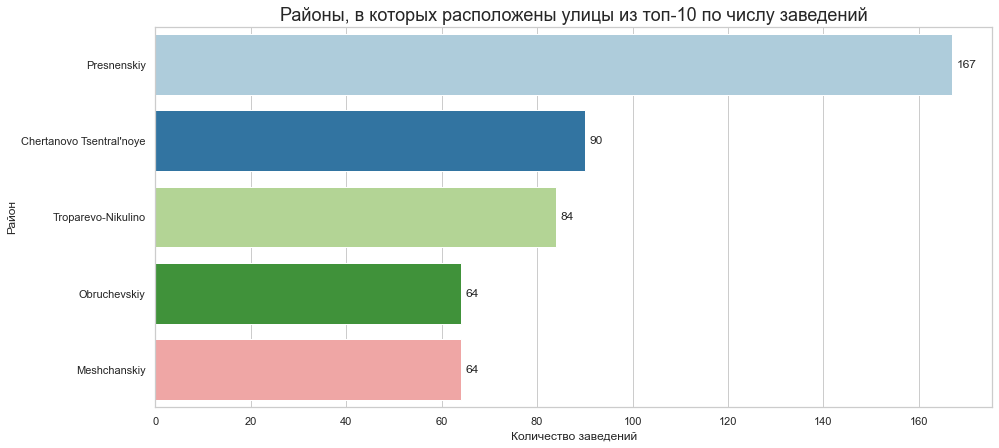

In [36]:
plt.figure(figsize=(15, 7))
ax = sns.barplot(x = 'id', y = 'district', data = all_district.head(), palette="Paired")


for p in ax.patches:
    height = p.get_height() 
    width = p.get_width() 
    ax.text(x = width+1, 
    y = p.get_y()+(height/2), 
    s = '{:.0f}'.format(width),
    va = 'center')
    
plt.xlabel('Количество заведений')
plt.ylabel('Район')
plt.title('Районы, в которых расположены улицы из топ-10 по числу заведений', fontsize = 18);
#plt.savefig('11.png');

Итого самые популряные улицы с точки зрения расположения заведений питания расположены в 37 районах Москвы, чаще всего в Пресненском районе, Чертаново-Центральное и Тропарево-Никулино.

Найдем число улиц с одним объектом общественного питания:

In [37]:
outsider = data.pivot_table(index='street', values='id', aggfunc='count').reset_index()
outsider = outsider.query('id==1')

In [38]:
outsider_list = outsider['street'].unique()
data.query('street in @outsider_list')

,id,object_name,chain,object_type,address,number,street
19,153644,американская лаборатория десертов,нет,кафе,"город москва, филипповский переулок, дом 15/5",20,филипповский переулок
61,21214,столовая,нет,столовая,"город москва, бабаевская улица, дом 3",90,бабаевская улица
69,22139,хуанхэ,нет,ресторан,"город москва, 1-й балтийский переулок, дом 3/25",60,1-й балтийский переулок
81,25833,азербайджан,нет,ресторан,"город москва, улица демьяна бедного, дом 4",180,улица демьяна бедного
131,150881,вгик,нет,столовая,"город москва, будайская улица, дом 3",45,будайская улица
...,...,...,...,...,...,...,...
14794,207728,столовая№ 1 пицца,нет,столовая,"город москва, поселение сосенское, посёлок газ...",35,посёлок газопровод
14798,223171,кондитерская «пряник.рогалик»,нет,кафе,"город москва, город троицк, пионерская улица, ...",20,пионерская улица
14807,214436,кафе,нет,буфет,"город москва, поселение ""мосрентген"", мкад, 44...",36,мкад
14974,213930,горячий хлеб,нет,fast food,"город москва, поселение десеновское, улица дми...",0,улица дмитрия рябинкина


Получили 595 улиц, на которых всего по 1 объекту питания. Проверим, в каких они находятся районах, воспользуюмся готовым файлом с полученными данными по геокоординатам.

In [39]:
url = 'https://docs.google.com/spreadsheets/d/1YN5xKFSkgcdkCPeBLXSpT_TdBgcV-2Wg-4CzdtEeao8/edit?usp=sharing'
url.split('/')
id = url.split('/')[5]
district_out = pd.read_csv(f'https://docs.google.com/spreadsheets/d/{id}/export?format=csv')
district_out

,id,object_name,chain,object_type,address,number,street,district
0,153644,американская лаборатория десертов,Несетевое,кафе,"город москва, филипповский переулок, дом 15/5",20,филипповский переулок,Arbat
1,21214,столовая,Несетевое,столовая,"город москва, бабаевская улица, дом 3",90,бабаевская улица,Sokol'niki
2,22139,хуанхэ,Несетевое,ресторан,"город москва, 1-й балтийский переулок, дом 3/25",60,1-й балтийский переулок,Aeroport
3,25833,азербайджан,Несетевое,ресторан,"город москва, улица демьяна бедного, дом 4",180,улица демьяна бедного,Khoroshevo-Mnevniki
4,150881,вгик,Несетевое,столовая,"город москва, будайская улица, дом 3",45,будайская улица,Rostokino
...,...,...,...,...,...,...,...,...
590,197170,пицца суши,нет,кафе,"город москва, поселение сосенское, посёлок ком...",8,"микрорайон ""эдальго""","Sosenskoye, Poseleniye"
591,194926,кулинарный рай,нет,кафе,"город москва, поселение внуковское, квартал № ...",70,квартал № 30,"Vnukovskoye, Poseleniye"
592,216767,кафе,нет,кафе,"город москва, 80-й километр московской кольцев...",20,80-й километр московской кольцевой автодороги,Dmitrovskiy
593,207728,столовая№ 1 пицца,нет,столовая,"город москва, поселение сосенское, посёлок газ...",35,посёлок газопровод,"Sosenskoye, Poseleniye"


In [40]:
all_district = district_out.pivot_table(index='district', 
                          values='id', 
                          aggfunc='count').reset_index().sort_values(by='id', ascending=False)
print('Улицы с 1 заведением расположены в', all_district['district'].count(), 'районах Москвы')
all_district

Улицы с 1 заведением расположены в 121 районах Москвы


,district,id
98,Taganskiy,28
29,Khamovniki,26
5,Basmannyy,22
104,Tverskoy,21
75,Presnenskiy,19
...,...,...
13,Chertanovo Severnoye,1
72,Perovo,1
28,Kapotnya,1
95,Staroye Kryukovo,1


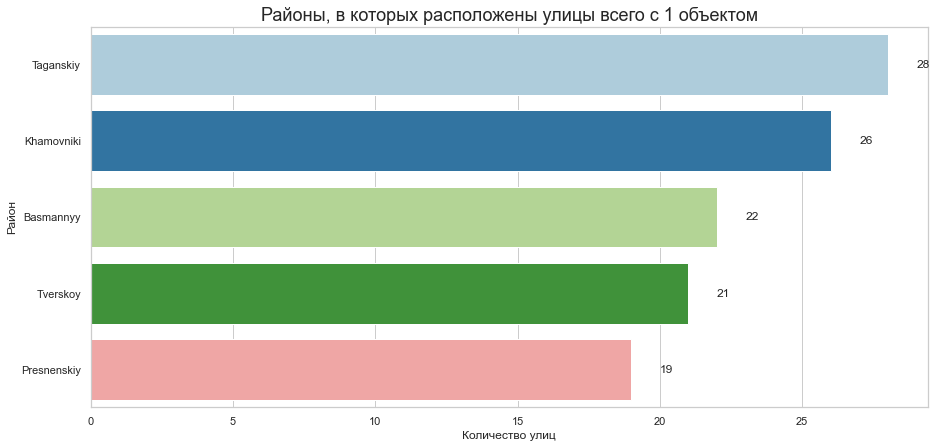

In [41]:
plt.figure(figsize=(15, 7))
ax = sns.barplot(x = 'id', y = 'district', data = all_district.head(), palette="Paired")


for p in ax.patches:
    height = p.get_height() 
    width = p.get_width() 
    ax.text(x = width+1, 
    y = p.get_y()+(height/2), 
    s = '{:.0f}'.format(width),
    va = 'center')
    
plt.xlabel('Количество улиц')
plt.ylabel('Район')
plt.title('Районы, в которых расположены улицы всего с 1 объектом', fontsize = 18);
#plt.savefig('12.png');

Итого лидирует по количеству улиц с всего 1 объектом питания Таганский - 28, а также Хамовники, Басманный и Тверской. Судя по-всему, это районы Москвы с достаточно небольшими улицами. 

## Выводы

В результате проекта были рассмотрены данные рынка общепита в Москве. В ходе предобработки данных не было обнаружено полных дубликатов, пропусков или каких-либо очевидных ошибок в данных. Все типы данных приведены к максимально удобным. Удалены неполные дубликаты(85 строк). Итоговый датасет содержал 15281 строку.

В ходе анализа было рассчитано соотношение объектов по их видам и построены необходимые диаграммы:  
* 40% объектов составляют кафе, в абсолютных величинах это 6071 объект  
* на втором месте по популярности столовые - 17%, 2584 объекста  
* Меньше всего кулинарий, закусочных и кафетериев, суммарно их менее 10% от общего числа.

Также было рассмотрено соотношение сетевых и несетевых заведений:
* сетевые заведения асболютно лидируют по количеству заведений 80,6% против сетевых 19,4%
* в абсолютных величинах это 12317 против 2964.

При этом:
* наиболее характерно сетевое распространение для fast foodов - 41,5% и кулинарий - 28,6% из них именно сетевые
* наименее распротранены сетевые столовые и буфеты
* абсолютное количество сетевых кафе больше fast foodов практически в два раза - 1396 против 788.

Анализ количества посадочных мест показал, что:
* наибольшее число посадочных мест в среднем пердлагают столовые - 130  
* далее следуют рестораны - 97  
* наименьшее число посадочных мест в закусочных, кулинариях, и кафетериях, в них посадочных мест вообще может и не быть
* у fast foodа при этом самый большой разброс значений среди заведений одного вида
* в зависимости от формата объекта (сетевой или нет) количество посадочных мест может отличаться, в среднем у сетевых заведений их больше.

Были проанализированы самые популярные улицы с точки зрения расположения на них объектов питания:
* лидер по количеству заведений - Проспект Мира - 203, 
* далее следуют Профсоюзная улица и Ленинградский проспект
* наименьшее количество объектов из топ-10 находятся на улице Кировоградской - 108шт
* данные улицы вышли в топ в основном благодаря своей бОльшей протяженности
* топ-10 улиц расположены в 37 районах Москвы: чаще всего в Пресненском районе, Чертаново-Центральное и Тропарево-Никулино.

Также были рассмотрены отдельно улицы, на которых находится всего по 1 объекту питания:
* таких улиц 595
* по количеству таких улиц лидирует Таганский район- 28, а 
* далее идут Хамовники, Басманный и Тверской
* данный районы находятся в центре города и удицы, попавшие в выборку скорее всего имеют малую протяженность.

Рекомендации по открытию заведения:
* лучше всего сосредоточить свое внимание на формате кафе, это наиболее частый и "простой" с точки зрения посетителя формат, тем более учитывая задумку с роботами-официантами
* в зависимости от экономических показателей после октрытия стоит задуматься о возможности откртыия небольшой сети данных кафе
* количество посадочных мест будет зависеть от помещения и геолокации, но лучше планировать 30-40, это средний показатель для кафе
* выбор локации всегда очень сложный вопрос для бизнеса, это всегда совокупность многих факторов, начиная от потока людей, заканчивая соседством с другими заведениями. В рамках данной имеющейся информации имеет смысл начать с районов и улиц, которые были определены нами с 1 заведением - Таганский, Хамовники, Басманный, Тверской. Это центральные районы города, где скорее всего будет хороший поток посетителей, а конкуренция пока не сильная. С другой стороны при более дательном изучении может оказаться, что там не просто так нет других заведений.

По результатам исследования была выполнена презентация:

Презентация: <https://drive.google.com/file/d/1mx--frSZoMQNWI0k2p-vT7_RMtPlVE27/view?usp=sharing>